### Running Palace

In [2]:
import numpy as np
from math import pi
import yaml

from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from zeroheliumkit import Rectangle, Anchor, Structure, Skeletone
from zeroheliumkit.src.settings import *
from zeroheliumkit.src.geometries import Meander, Rectangle, ArcLine
from zeroheliumkit.helpers.resonator_calc import CPW_params

from zeroheliumkit.fem import GMSHmaker, ExtrudeSettings, SurfaceSettings, PECSettings, MeshSettings, BoxFieldMeshSettings, DistanceFieldMeshSettings

In [3]:
um = 1e-6
GHz = 1e9
plot_config = {
    "wafer": LIGHTGRAY,
    "gnd": BLUE,
    "open": ORANGE,
    "temp": WHITE,
    "island": YELLOW2,
    "ports": RED,
    "anchors": RED
}

In [4]:
def construct_resonator_skeletone(params: dict) -> LineString:
    g_params = params["geometry"]
    d_a = g_params['coupling_length']
    d_w = g_params['distance_from_waveguide']
    d_l = g_params['openend_length']
    d_R = g_params['radius']
    n = g_params['num']
    w = g_params["w"]
    g = g_params["g"]

    cpw_params = CPW_params(params["eps"], w * um, g * um, params["substrate_h"] * um, 0)
    cpw_params.resonator_length(params["frequency"] * GHz, params["type"], 0)
    length = cpw_params.length/um
    
    d_b = (length - (d_l + d_a + d_w + d_R * (3 * pi/2 + 2 * pi * n + 1)))/(2 * n + 1)
    if d_b < 0:
        raise Exception("Incorrect geometry input. Choose different 'bending_radius', 'coupling_length', 'openend_length' or 'num_wiggles'")

    sk = Skeletone()
    sk.add(LineString([(0, 0), (0, d_l)]))
    sk.add(ArcLine(-d_R, 0, d_R, 0, 90, 6))
    sk.add(LineString([(0, 0), (-d_a, 0)]))
    sk.add(ArcLine(0, -d_R, d_R, 90, 180, 6))
    sk.add(LineString([(0, 0), (0, -d_w)]))
    sk.add(ArcLine(d_R, 0, d_R, 180, 270, 6))
    sk.add(LineString([(0, 0), (d_b/2, 0)]), ignore_crossing=True)
    for _ in range(n):
        sk.add(Meander(d_b, d_R, direction=-90, num_segments=12), ignore_crossing=True)
    sk.add(LineString([(0, 0), (d_b/2 + d_R, 0)]))

    return sk

In [ ]:
### Creating Geometry

-------  ----------  ---------  -------  ---  -------  --------------  -------  -------
f0, GHz  length, mm  width, um  gap, um  eps  eps_eff  impedance, Ohm  L, nH/m  C, pF/m
7.7      3.974       8.0        4.5      11   6.0      52.57           429.52   155.423
-------  ----------  ---------  -------  ---  -------  --------------  -------  -------


<Axes: >

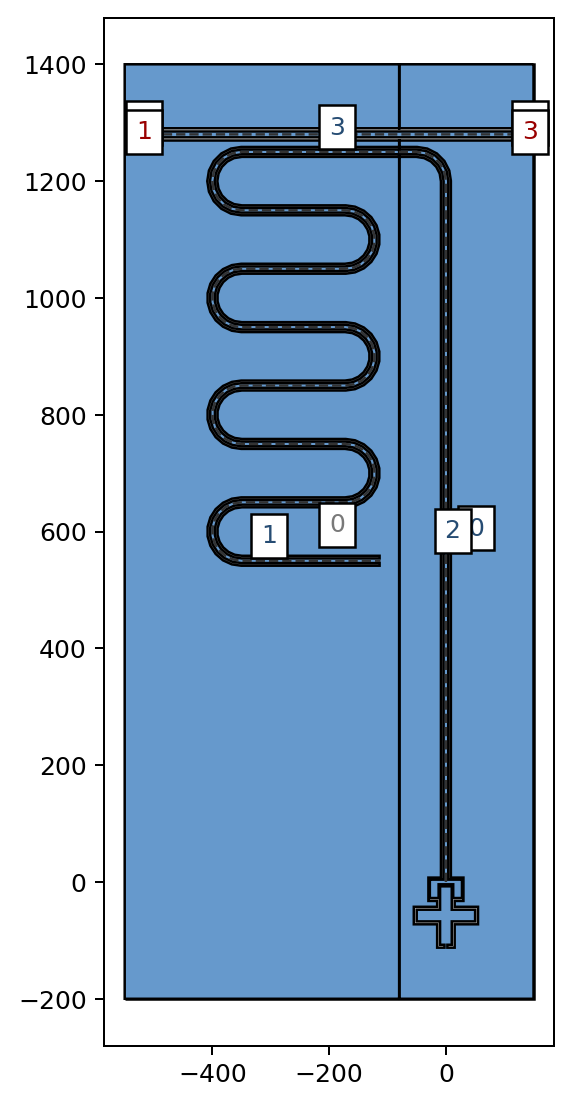

In [6]:
with open('params.yaml', 'r') as file:
    params = yaml.safe_load(file)

gp = params["resonator"]["geometry"]
fc = params["feedline"]

d = Structure()
d.skeletone = construct_resonator_skeletone(params["resonator"])
d.add_layer("open", d.skeletone.buffer(gp["w"]/2 + gp["g"], cap_style="square", join_style="mitre"))
# d.buffer_line("open", gp["w"]/2 + gp["g"], cap_style="square", join_style="mitre")
d.skeletone.add(LineString([(0, 0), (10, 0)]))
d.add_layer("temp", d.skeletone.buffer(gp["w"]/2, cap_style="square", join_style="mitre"))
# d.buffer_line("temp", gp["w"]/2, cap_style="square", join_style="mitre")
d.anchors.add([Anchor((0,0), -90, "end")])

island = Structure()
island.add_layer("island", Rectangle(100, 20, (0,0)))
island.add_polygon("island", Rectangle(20, 100, (0,0)))
island.add_layer("open", island.island.buffer(5, join_style='mitre'))
island.anchors.add([Anchor((0, 57.5), -90, "isl")])

d.append(island, anchoring=("end", "isl"))
d.add_polygon("open", Rectangle(60, 40, (0, 45 - 57.5)))
d.cut_polygon("open", Rectangle(15, 30, (20, 45 - 57.5)))
d.cut_polygon("open", Rectangle(15, 30, (-20, 45 - 57.5)))
d.cut_polygon("open", Rectangle(55, 8, (0, 0)))
d.cut_polygon("open", d.temp)
d.remove_layer("temp")
d.anchors.remove("isl", "end")

d.add_layer("wafer", Rectangle(700, 1600, (-200, 600)))
d.add_layer("gnd", Rectangle(700, 1600, (-200, 600)))
d.cut_polygon("gnd", d.open)
d.remove_layer("open")

bbox = d.skeletone.lines.bounds
y_offset = 30
x_offset = 130
y_feedline = bbox[3] + y_offset
fdl = Structure()
fdl.skeletone.add(LineString([(bbox[0] - x_offset, y_feedline), (bbox[2] + x_offset, y_feedline)]))
fdl.add_layer("gnd", fdl.skeletone.buffer(fc["w"]/2 + fc["g"], cap_style="square", join_style="mitre"))
fdl.cut_polygon("gnd", fdl.skeletone.buffer(fc["w"]/2, cap_style="square", join_style="mitre"))

d.cut_polygon("gnd", fdl.gnd)
d.add_layer("ports", Rectangle(4, 200, (bbox[0] - x_offset, y_feedline)))
d.add_polygon("ports", Rectangle(4, 200, (bbox[2] + x_offset, y_feedline)))
d.cut_polygon("ports", d.gnd)

d.add_polygon("gnd", d.island)

bbox_island = d.island.bounds
# adding gnd to the island
d.add_polygon("gnd", Rectangle(5, 10, (bbox_island[0]/2 + bbox_island[2]/2, bbox_island[1])))

d.remove_layer("island")

d.skeletone.add(fdl.skeletone.lines, chaining=False)
msh_lines = d.skeletone
d.remove_holes_from_polygons("gnd", cut_position=-80)


d.quickplot(plot_config, show_idx=True)

In [ ]:
### Creating Mesh

In [7]:
d_wafer     = 200
d_vac       = 200
d_metal     = 100

msh_filename = 'cpw'
save_dir = 'postpro/'

In [14]:
Volumes = {
    "wafer": ExtrudeSettings(d.wafer, -d_wafer, d_wafer, "DIELECTRIC"),
    # "top": ExtrudeSettings(d.top, 0, d_metal, "METAL"),
    "vacuum": ExtrudeSettings(d.wafer, 0, d_vac, "VACUUM")
}

Surfaces = {
    "s0": SurfaceSettings(d.gnd, 0),
    "s1": SurfaceSettings(d.ports, 0)
}

PECs = {
    "conductor": PECSettings(d.gnd, [0,1,2,3], z=0),
    "port1+": PECSettings(d.ports, [0], z=0),
    "port1-": PECSettings(d.ports, [1], z=0),
    "port2+": PECSettings(d.ports, [2], z=0),
    "port2-": PECSettings(d.ports, [3], z=0)
}

mesh = MeshSettings(
    dim = 3,
    fields = {"Box": [BoxFieldMeshSettings(Thickness=400, VIn=1000, VOut=2000, box=[-10000, 10000, -10000, 10000, -1000, 1000])],
              "Distance": [DistanceFieldMeshSettings(geometry=msh_lines.lines, base_z=0, sampling=100, SizeMin=10, SizeMax=80, DistMin=10, DistMax=30)]},
)

In [15]:
mshmkr = GMSHmaker(
    extrude = Volumes,
    surfaces = Surfaces,
    pecs = PECs,
    mesh = mesh,
    save = {"dir": save_dir, "filename": msh_filename},
    open_gmsh = True,
    debug_mode = False
)

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation  |███| 1/1 [100%] in 1.5s (0.66/s)                              


In [16]:
mshmkr.print_physical()

Volume        ID
----------  ----
VACUUM         1
DIELECTRIC     2

 #-----------------------------------

Surface      ID
---------  ----
conductor     3
port1+        4
port1-        5
port2+        6
port2-        7


Below is an example of created geometry and a mesh using GMSH.

<img src="../_static/fig2.png" width="800"/>

In [ ]:
### Configuring Palace Simulation

In [17]:
from zeroheliumkit.fem.palacer import (PalaceRunner, PalaceConfig, ProblemConfig, ModelConfig,
                                       MaterialsConfig, PostProEnergyConfig, PostProProbeConfig,
                                       DomainConfig, ElementConfig, LumpedPortConfig, BoundaryConfig,
                                       DrivenConfig, EigenConfig, SolverConfig)

In [ ]:
### Frequency sweep

In [30]:
problem_cfg = ProblemConfig(Type="Driven", Verbose=2, Output="postpro/")
model_cfg = ModelConfig(Mesh="postpro/cpw.msh2", L0=1.0e-6, Refinement={"Tol": 1.0e-2, "MaxIts": 10, "MaxSize": 1e6})

air = MaterialsConfig(Attributes=[2], Permeability=1.0, Permittivity=1.0, LossTan=0.0)
silicon = MaterialsConfig(Attributes=[1], Permeability=1.0, Permittivity=11, LossTan=0.0)

postpro = {"Energy": [PostProEnergyConfig(Index=1, Attributes=[1])],
          }

domain_cfg = DomainConfig(Materials=[air, silicon], Postprocessing=postpro)

lp1_cfg = LumpedPortConfig(Index=1, R=50.0, Excitation=1, Elements=[ElementConfig([4],"+Y"), ElementConfig([5],"-Y")])
lp2_cfg = LumpedPortConfig(Index=2, R=50.0, Excitation=0, Elements=[ElementConfig([6],"+Y"), ElementConfig([7],"-Y")])

boundary_cfg = BoundaryConfig(PEC={"Attributes": [3]},
                              LumpedPort=[lp1_cfg, lp2_cfg])


f1 = 7.0
f2 = 7.4
df = (f2 - f1)/100

solver_cfg = SolverConfig(Order=2, Device="CPU", Driven=DrivenConfig(MinFreq=f1, MaxFreq=f2, FreqStep=df, Save=[f1,f2], AdaptiveTol=1.0e-3))

In [31]:
palace_app_path = "/Users/helium/spack/opt/spack/darwin-m1/palace-0.14.0-2v4weqz6drx675yhbuoyu2nmnqolzf5n/bin/palace"

palace_cfg = PalaceConfig(Problem=problem_cfg,
                          Model=model_cfg,
                          Domains=domain_cfg,
                          Boundaries=boundary_cfg,
                          Solver=solver_cfg)

pal = PalaceRunner(json_name="fsweep", config=palace_cfg, exec_path=palace_app_path)

In [32]:
# this has been tested only on macs, windows may have issues with multiprocessing
# json config file is already created, refer to AWS Palace website for more information

pal.run(multicore=8)

tab 1 of window id 49921


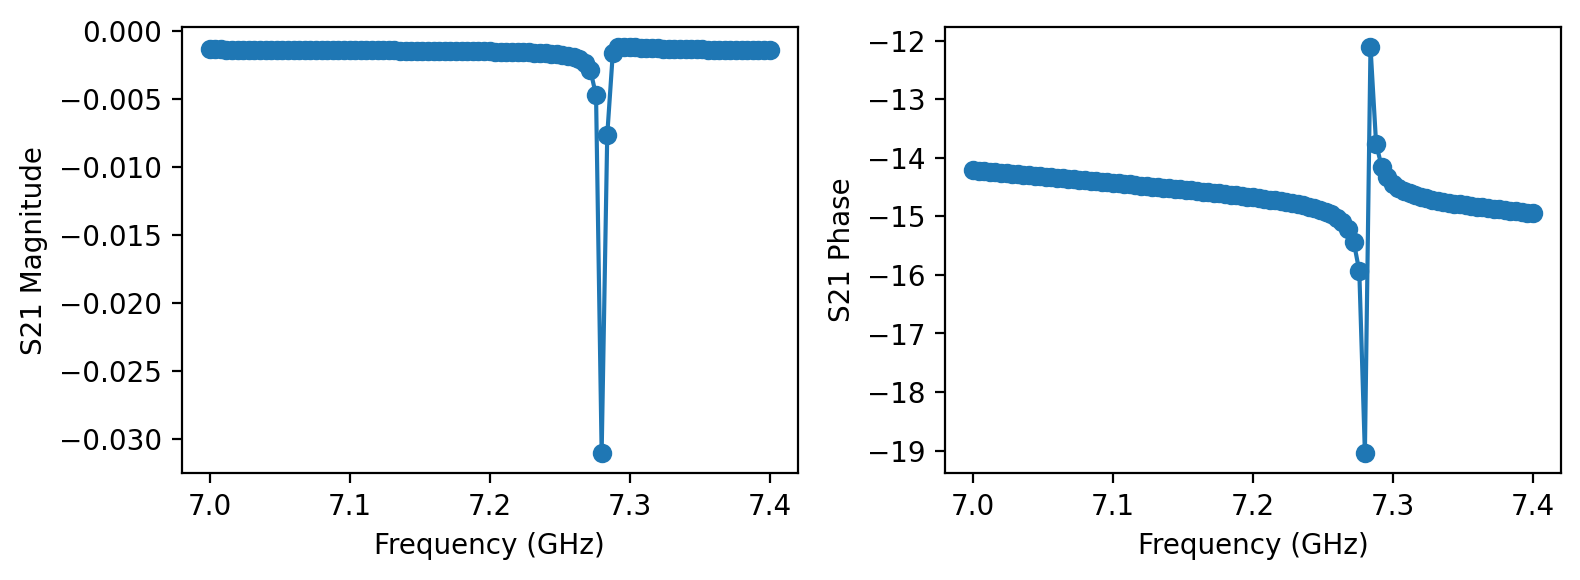

In [33]:
data = np.loadtxt('postpro/port-S.csv', skiprows=1, delimiter=',')

plt.figure(figsize=(8,3))

ax1 = plt.subplot(121)
ax1.plot(data[:,0], data[:,3], '-o')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('S21 Magnitude')

ax2 = plt.subplot(122)
ax2.plot(data[:,0], data[:,4], '-o')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('S21 Phase')


plt.tight_layout()
plt.show()

In [ ]:
### Eigenfrequency calculations

In [36]:
problem_cfg = ProblemConfig(Type="Eigenmode", Verbose=2, Output="postpro/")
model_cfg = ModelConfig(Mesh="postpro/cpw.msh2", L0=1.0e-6, Refinement={"Tol": 1.0e-2, "MaxIts": 10, "MaxSize": 1e6})

air = MaterialsConfig(Attributes=[1], Permeability=1.0, Permittivity=1.0, LossTan=0.0)
silicon = MaterialsConfig(Attributes=[2], Permeability=1.0, Permittivity=11, LossTan=0.0)

postpro = {"Energy": [PostProEnergyConfig(Index=1, Attributes=[1])],
          }

domain_cfg = DomainConfig(Materials=[air, silicon], Postprocessing=postpro)

boundary_cfg = BoundaryConfig(PEC={"Attributes": [3]},
                              LumpedPort=[])


solver_cfg = SolverConfig(Order=2, Device="CPU", Eigenmode=EigenConfig(N=2, Tol=1e-6, Target=6.5, Save=2))

In [37]:
palace_cfg = PalaceConfig(Problem=problem_cfg,
                          Model=model_cfg,
                          Domains=domain_cfg,
                          Boundaries=boundary_cfg,
                          Solver=solver_cfg)

pal = PalaceRunner(json_name="eigen", config=palace_cfg, exec_path=palace_app_path)

In [6]:
eigen = np.loadtxt('postpro/eig.csv', skiprows=1, delimiter=',')
print("Eigenfrequencies (GHz):")
print(eigen[:,1])

Eigenfrequencies (GHz):
[ 7.35171928 16.86640487 22.08328345 32.6005022  36.81162642]


In [38]:
pal.run(multicore=8)

tab 1 of window id 49926


Statistics             |  Electric Field (first mode at 7.35171928 GHz)
:-------------------------:|:-------------------------:
<img src="../_static/fig3.png" width="500"/>  |  <img src="../_static/fig4.png" width="800"/>